In [1]:
import numpy as np
import matplotlib.pyplot as plt
from well import Well
from geometry_keeper import GeometryKeeper
from scipy.integrate import quad
from scipy.special import k0, iti0k0

In [2]:
from multifrac import Multifrac

In [3]:
####
from time import time
dx = 1./params["nseg"]

su = s**0.5
orig_shape = (nwells*2*params["nseg"], nwells*2*params["nseg"])
orig_geo = mf_lapl.geo.reshape(nwells*2*params["nseg"], nwells*2*params["nseg"],5)
resh_geo = mf_lapl.geo.reshape(-1,5)
ans = np.zeros(resh_geo.shape[0])
def g(x_, dyd, su):
    return 0.5*k0(su*(x_*x_+dyd*dyd)**0.5)
def f(x):
    return quad(g, x[0]-dx, x[0], args=(x[1], su))[0]
t1 = time()
## find elements where dyd == 0
dyd_0_inds = np.argwhere(resh_geo[:,2] == 0).flatten()
dyd_nnz_inds = np.argwhere(resh_geo[:,2] != 0).flatten()
print(resh_geo.shape)
## select these items from the all items
dyd_0 = resh_geo[dyd_0_inds]
## select values from the first and second columns:
lims1 = dyd_0[:,0]
n_lims1 = len(lims1)
lims2 = dyd_0[:,1]
mask1 = dyd_0[:,-2]
mask2 = dyd_0[:,-1]
lims = np.append(lims1, lims2)
ulims, inds = np.unique(lims, return_inverse=True)
print(len(ulims))
uvals = 0.5/su*(iti0k0(su*ulims)[1])
vals = uvals[inds]
vals1 = vals[:n_lims1]
vals2 = vals[n_lims1:]
assert len(vals1) == len(vals2)
true_vals = vals1*mask1 + vals2*mask2
ans[dyd_0_inds] = true_vals
print("t1: {}".format(time()-t1))
## calc items with dyd <> 0
t1 = time()
dyd_nnz = resh_geo[dyd_nnz_inds][:,:3]
dyd_lims = dyd_nnz[:,:2]
dyd_upper_lims = np.max(dyd_lims, axis=1).reshape(-1,1)
dyd_upper_lims = np.hstack([dyd_upper_lims, dyd_nnz[:,-1].reshape(-1,1)])
dyd_unique_items, indices = np.unique(dyd_upper_lims, axis=0, return_inverse=True)
dyd_unique_vals = np.apply_along_axis(f, 1, dyd_unique_items)
dyd_vals = dyd_unique_vals[indices]
ans[dyd_nnz_inds] = dyd_vals
ans = ans.reshape(orig_shape)
print("t2: {}".format(time()-t1))

print("calculate simply")
def foo(x):
    if x[2] == 0.:
        return 0.5/su*(iti0k0(su*x[0])[1]*x[-2]+iti0k0(su*x[1])[1]*x[-1])
    else:
        ulim = max(x[0], x[1])
        return quad(g, ulim-dx, ulim, args=(x[2], su))[0]

t1 = time()
straight_ans = np.apply_along_axis(foo, 2, orig_geo)
print("t3: {}".format(time()-t1))
print(np.allclose(ans, straight_ans))

NameError: name 'params' is not defined

In [4]:
outer_bound = "infinite"
top_bound = "imp"
bottom_bound = "imp"
wtype = "frac"
n_stehf = 10
xwd = 0.
ywd = 0.
N = 40

params = {"nseg": N, "kx": 1., "ky": 1., "kz": 1., "omega": 1, "lambda": 1, "Fcd":100, "ref_length":1.,
         "z_ref_length": 1}
real_well = Well(xwd, ywd, outer_bound, top_bound, bottom_bound, wtype, params, n_stehf)
well = real_well.lapl_well

dyd = 1.
xws = np.array([0., 0., 0., 0., 0.])
yws = np.array([2*dyd, dyd, 0., -dyd, -2*dyd])
nwells = 5
mf = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf)
mf2 = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf, "fixed_quad", 5)
mf_lapl = mf.lapl_well 
######


s = 1120

orig_shape = (nwells*params["nseg"]*2, nwells*params["nseg"]*2)
source_m  = mf_lapl.get_source_matrix(s)
right_matrix = well.get_green_matrix(s)
geo = mf_lapl.geo
green_matrix = np.zeros(geo.shape[0])
dyd_0_inds = np.argwhere(geo[:, 2] == 0.).flatten()
items_dyd_0 = geo[dyd_0_inds]
lims1 = items_dyd_0[:,0]
lims2 = items_dyd_0[:,1]
n_lims1 = len(lims1)
lims = np.append(lims1, lims2)
mask_1 = items_dyd_0[:,-2]
mask_2 = items_dyd_0[:,-1]
ulims, inds = np.unique(lims, return_inverse = True)
uvals = well.source.integrate_source_functions(s,
        np.zeros_like(ulims, dtype=np.float),
        ulims,
        np.zeros_like(ulims, dtype=np.float))
vals = uvals[inds]
vals1 = vals[:n_lims1]
vals2 = vals[n_lims1:]
vals = vals1*mask_1 + vals2*mask_2
green_matrix[dyd_0_inds] = vals
dyd_nnz_inds = np.argwhere(geo[:, 2] > 0.).flatten()
items_dyd_nnz = geo[dyd_nnz_inds][:,:3]
lims = items_dyd_nnz[:,:2]
upper_lims = np.max(lims, axis=1).reshape(-1, 1)
upper_lims_dyds = np.hstack([upper_lims, items_dyd_nnz[:,-1].reshape(-1, 1)])
ulims_dyd_nnz, inds_dyd_nnz = np.unique(upper_lims_dyds, axis=0, return_inverse=True)
uvals_dyd_nnz = well.source.integrate_source_functions(s,
        ulims_dyd_nnz[:, 0] - 1./params["nseg"],
        ulims_dyd_nnz[:, 0],
        ulims_dyd_nnz[:, 1])
vals_dyd_nnz = uvals_dyd_nnz[inds_dyd_nnz]
green_matrix[dyd_nnz_inds] = vals_dyd_nnz
green_matrix = green_matrix.reshape(orig_shape)
# green_matrix[:2*N, 2*N:] = 0.
# green_matrix[2*N:4*N, :2*N] = 0.
# green_matrix[2*N:4*N, 4*N:] = 0.
# green_matrix[4*N:,:4*N] = 0.
print(np.allclose(green_matrix[:2*params["nseg"],:2*params["nseg"]], right_matrix))
print(np.allclose(green_matrix[2*params["nseg"]:4*params["nseg"],2*params["nseg"]:4*params["nseg"]], right_matrix))
print(np.allclose(green_matrix[4*params["nseg"]:6*params["nseg"],4*params["nseg"]:6*params["nseg"]], right_matrix))
source_matrix = mf_lapl.get_source_matrix(s)
right_part = mf_lapl.get_right_part(s)
right_part[-1] = right_part[-1]
true_right_part = well.get_right_part(s)
true_source_matrix = well.get_source_matrix(s)
combined_matrix = np.zeros((1+nwells*params["nseg"]*2, 1+nwells*params["nseg"]*2), dtype = np.float)
combined_matrix[:-1,0] = 1.
combined_matrix[-1, 1:] = 1.
combined_matrix[:-1, 1:] = source_matrix - green_matrix
true_e_green_matrix = well.ext_green_matrix(right_matrix)
true_dummy_matrix = well.get_dummy_matrix()
true_combined_matrix = true_dummy_matrix - true_e_green_matrix + true_source_matrix
print("######")
solution = np.linalg.solve(combined_matrix, right_part)
true_solution = np.linalg.solve(true_combined_matrix, true_right_part)
print(solution[0])
print(true_solution[0])
print(true_solution[0]/solution[0])

True
True
True
######
1.00977552514e-05
5.04887762572e-05
5.0


In [5]:
t = .1
print(real_well.get_pw(t))
print(mf.get_pw(t))
print(real_well.get_pw(t)/mf.get_pw(t))

0.504305087508
0.102464388687
4.92175958859


In [6]:
ts = np.logspace(-3, 0, 30)

In [7]:
singles = []

for t in ts:
    singles.append(real_well.get_pw(t))


In [16]:
from time import time
multi = []
t1 = time()
for t in ts:
    multi.append(mf.get_pw(t))
print("done in {} s".format(time()-t1))

done in 104.1449568271637 s


In [11]:
import matplotlib.pyplot as plt
% matplotlib inline

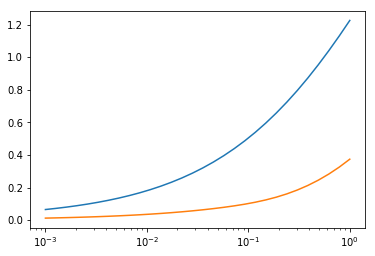

In [11]:
plt.xscale("log")
plt.plot(ts, singles)
plt.plot(ts, multi)

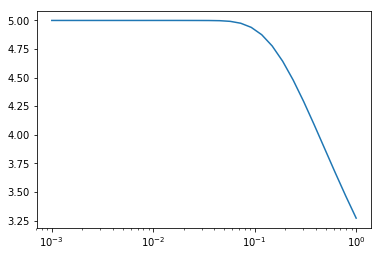

In [12]:
plt.xscale("log")
singles = np.array(singles)
multi = np.array(multi)
plt.plot(ts, singles/multi)

### Here I found that multifrac is Ok

In [13]:
mf2 = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf, "fixed_quad", 5)

In [15]:
from time import time
multi2 = []
t1 = time()
for t in ts:
    multi2.append(mf2.get_pw(t))
print("done in {} s".format(time()-t1))

done in 94.00137662887573 s


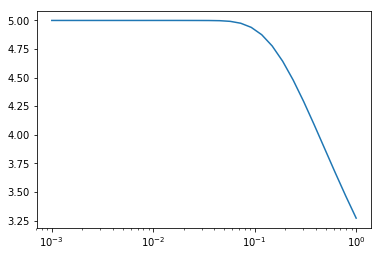

In [20]:
plt.xscale("log")
multi2 = np.array(multi2)
plt.plot(ts, singles/multi2)

In [15]:
dxd = 1.
xws = np.array([-2*dxd,  0.,  2*dxd])
yws = np.array([0., 0., 0.])
nwells = 3
mf3 = Multifrac(nwells, xws, yws, outer_bound, top_bound, bottom_bound, params, n_stehf)

In [16]:
multi3 = []
t1 = time()
for t in ts:
    multi3.append(mf3.get_pw(t))
print("done in {} s".format(time()-t1))

done in 7.515429973602295 s


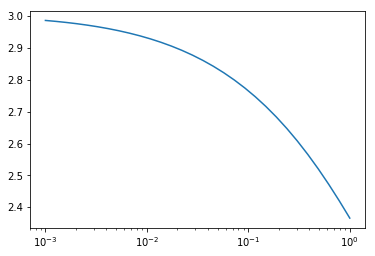

In [17]:
multi3 = np.array(multi3)
plt.xscale("log")
plt.plot(ts, singles/multi3)

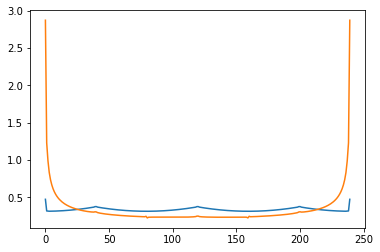

In [19]:
plt.plot(mf3.get_source_distribution(1e-3))
plt.plot(mf3.get_source_distribution(10))

In [22]:
mf3.lapl_well.geo

array([[ 0.0125,  0.0125,  0.    ,  1.    ,  1.    ],
       [ 0.0125,  0.0375,  0.    , -1.    ,  1.    ],
       [ 0.0375,  0.0625,  0.    , -1.    ,  1.    ],
       ..., 
       [ 0.0625,  0.0375,  0.    ,  1.    , -1.    ],
       [ 0.0375,  0.0125,  0.    ,  1.    , -1.    ],
       [ 0.0125,  0.0125,  0.    ,  1.    ,  1.    ]])

In [27]:
np.vectorize?

In [24]:
from scipy.special import k0

In [25]:
def g(x, su, dyd):
    return k0(su*(x*x+dyd*dyd)**0.5)

In [26]:
def f(lim1, lim2, su, dyd):
    return quad(g, lim1, lim2, args=(su, dyd))

In [28]:
vf = np.vectorize(f)

In [31]:
lims1 = mf3.lapl_well.geo[:,0]
lims2 = mf3.lapl_well.geo[:,1]
dyds = mf3.lapl_well.geo[:,2]+1.

In [46]:
t1 = time()
vf(lims1, lims2, 1, dyds)[0]
print(time()-t1)

5.363306760787964


In [37]:
sub_ary = mf3.lapl_well.geo[:, :3]
sub_ary[:,-1] += 1.

In [38]:
sub_ary

array([[ 0.0125,  0.0125,  1.    ],
       [ 0.0125,  0.0375,  1.    ],
       [ 0.0375,  0.0625,  1.    ],
       ..., 
       [ 0.0625,  0.0375,  1.    ],
       [ 0.0375,  0.0125,  1.    ],
       [ 0.0125,  0.0125,  1.    ]])

In [43]:
def ff(x, su=None):
    return quad(g, x[0], x[1], args=(su, x[2]))[0]

In [47]:
t1 = time()
np.apply_along_axis(ff, 1, sub_ary, su=1.)
print(time()-t1)

9.569547414779663
